# Federated Learning Case Study

## 05. FL CICIDS - Experimentation with different client configurations

In this notebook, we devise a set of client configurations based on how the training data could be split across these. We use four schemes: individual IPs, individual attacks, group of IPs (based on similar OS), and group of attacks (based on name/type similarity).

We use our previous model and can deploy each of these scenarios to the FL process.

In [6]:
### THIS SECTION NEEDS TO BE SET TO DETERMINE WHICH CONFIGURATION METHOD TO UTILISE

AVAILABLE_METHODS = ['INDIVIDUAL_IP', 'GROUP_IP', 'INDIVIDUAL_ATTACK', 'GROUP_ATTACK', 'STRATIFIED']
METHOD = AVAILABLE_METHODS[4]
NUM_OF_STRATIFIED_CLIENTS = 10 # only applies to stratified method
print (METHOD)

STRATIFIED


In [7]:
import pandas as pd
import numpy as np

In [8]:
feature_df = pd.read_pickle('full_cicids_df.pkl')
# feature_df.head(5)

In [9]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Pre-processing to tidy up NaN values
feature_df2 = feature_df.replace([np.inf, - np.inf], np.nan)
feature_df2 = feature_df2.dropna()    
label = feature_df2['Label']
le = preprocessing.LabelEncoder()
label_n = le.fit_transform(label.values)

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(feature_df2, label_n, stratify=label_n, test_size=0.2, random_state=42)
#feature_df2 = feature_df2.drop(['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'Label'], axis=1)
feature_df2 = feature_df2.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp', 'Label'], axis=1)

# Scaling of features to fit within defined range
scaled_features = StandardScaler().fit_transform(feature_df2.values)
X_train, X_test, y_train, y_test = train_test_split(scaled_features, label_n, stratify=label_n, test_size=0.2, random_state=42)

print ("Train:", X_train.shape, y_train.shape)
print ("Test:", X_test.shape, y_test.shape)

Train: (1680016, 76) (1680016,)
Test: (420005, 76) (420005,)


In [10]:
known_ip_addresses = [ '192.168.10.25', '192.168.10.15', '192.168.10.14', '192.168.10.8', '192.168.10.5', '192.168.10.9', '192.168.10.12', '192.168.10.16', '192.168.10.17', '192.168.10.19', '192.168.10.51', '192.168.10.50']
print ("known ip addresses:", known_ip_addresses)
os_groups = [ ['192.168.10.25'],  #macOS
                ['192.168.10.15', '192.168.10.14', '192.168.10.8', '192.168.10.5', '192.168.10.9'], #win
                ['192.168.10.12', '192.168.10.16', '192.168.10.17', '192.168.10.19', '192.168.10.51', '205.174.165.66'], #ubuntu
                ['192.168.10.50', '205.174.165.68'], # webserver
                ]
print ("os_groups:", os_groups)


known ip addresses: ['192.168.10.25', '192.168.10.15', '192.168.10.14', '192.168.10.8', '192.168.10.5', '192.168.10.9', '192.168.10.12', '192.168.10.16', '192.168.10.17', '192.168.10.19', '192.168.10.51', '192.168.10.50']
os_groups: [['192.168.10.25'], ['192.168.10.15', '192.168.10.14', '192.168.10.8', '192.168.10.5', '192.168.10.9'], ['192.168.10.12', '192.168.10.16', '192.168.10.17', '192.168.10.19', '192.168.10.51', '205.174.165.66'], ['192.168.10.50', '205.174.165.68']]


In [11]:
attacks = label.unique()
attack_groups = [['BENIGN'],
                    ['DoS slowloris',
       'DoS slowloris - Attempted', 'DoS Slowhttptest',
       'DoS Slowhttptest - Attempted', 'DoS Hulk', 'DoS Hulk - Attempted',
       'DoS GoldenEye', 'DDoS'],
                    ['FTP-Patator', 'SSH-Patator', 'FTP-Patator - Attempted',
       'SSH-Patator - Attempted'],
                    ['Heartbleed'],
                    ['Web Attack - Brute Force', 'Web Attack - Brute Force - Attempted', 'Web Attack - XSS - Attempted', 'Web Attack - XSS',
       'Web Attack - Sql Injection'], 
                    ['Bot - Attempted', 'Bot'],
                    ['PortScan'],
                    ['Infiltration - Attempted', 'Infiltration']
]

In [12]:
fl_X_train = []
fl_y_train = []

if METHOD == AVAILABLE_METHODS[0]:
    #### Group by individual IP (src and dst)
    for i in known_ip_addresses:
        new_i = [i]
        print (new_i)
        new_df_src = X_train_df[ X_train_df['Src IP'].isin(new_i) ]
        new_df_dst = X_train_df[ X_train_df['Dst IP'].isin(new_i) ]
        #new_df = pd.concat([new_df1, new_df2], axis=0)

        X_np = np.vstack([ X_train[ new_df_src.index, : ], X_train[ new_df_dst.index, :] ])
        y_np = np.hstack([ y_train[ new_df_src.index ], y_train[ new_df_dst.index ] ])

        print (X_np.shape)
        print (y_np.shape)

        fl_X_train.append(X_np)
        fl_y_train.append(y_np) 
elif METHOD == AVAILABLE_METHODS[1]:
    #### Group by OS (src and dst)

    for i in os_groups:
        new_i = i
        print (new_i)
        new_df_src = X_train_df[ X_train_df['Src IP'].isin(new_i) ]
        new_df_dst = X_train_df[ X_train_df['Dst IP'].isin(new_i) ]
        #new_df = pd.concat([new_df1, new_df2], axis=0)

        X_np = np.vstack([ X_train[ new_df_src.index, : ], X_train[ new_df_dst.index, :] ])
        y_np = np.hstack([ y_train[ new_df_src.index ], y_train[ new_df_dst.index ] ])

        print (X_np.shape)
        print (y_np.shape)

        fl_X_train.append(X_np)
        fl_y_train.append(y_np) 
elif METHOD == AVAILABLE_METHODS[2]:
    #### Group by individual attack
    for i in attacks:
        new_i = [i]
        print (new_i)
        new_df_attack = X_train_df[ X_train_df['Label'].isin(new_i) ]
        #new_df = pd.concat([new_df1, new_df2], axis=0)

        X_np = X_train[ new_df_attack.index, : ]
        y_np = y_train[ new_df_attack.index ]

        print (X_np.shape)
        print (y_np.shape)

        fl_X_train.append(X_np)
        fl_y_train.append(y_np)
elif METHOD == AVAILABLE_METHODS[3]:
    #### Group by attack group

    for i in attack_groups:
        new_i = i
        print (new_i)
        new_df_attack_group = X_train_df[ X_train_df['Label'].isin(new_i) ]

        X_np = X_train[ new_df_attack_group.index, : ]
        y_np = y_train[ new_df_attack_group.index ]

        print (X_np.shape)
        print (y_np.shape)

        fl_X_train.append(X_np)
        fl_y_train.append(y_np) 
elif METHOD == AVAILABLE_METHODS[4]:
    ## 1. STRATIFIED SAMPLING
    from sklearn.model_selection import StratifiedKFold
    

    skf = StratifiedKFold(n_splits=NUM_OF_STRATIFIED_CLIENTS, shuffle=True, random_state=42)
    skf.get_n_splits(X_train, y_train)

    for _, test_index in skf.split(X_train, y_train):
        fl_X_train.append(X_train[test_index])
        fl_y_train.append(y_train[test_index]) 

C:\Users\pa-legg\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


In [13]:
len(label.unique())

25

In [ ]:
# CHECK IF THIS REMAINS THE SAME OR CHANGED
NUM_OF_CLIENTS = len(fl_X_train)
print ("NUM_OF_CLIENTS:", NUM_OF_CLIENTS)

NUM_OF_ROUNDS = 5

print ("Checking data split groups")
for i in range(len(fl_X_train)):
    print (i, ':', "X shape", fl_X_train[i].shape, " Y shape:" , fl_y_train[i].shape)

print ("Importing Federated Learning environment...")

import os
import flwr as fl
import numpy as np
import tensorflow as tf
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("tf", tf.__version__)
# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation

class NumpyFlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, model, train_data, train_labels):
        self.model = model
        self.cid = cid
        self.train_data = train_data
        self.train_labels = train_labels

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Training...")
        self.model.fit(self.train_data, self.train_labels, epochs=1, batch_size=32)
        print ("Client ", self.cid, "Training complete...")
        return self.model.get_weights(), len(self.train_data), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Evaluating...")
        loss, accuracy = self.model.evaluate(self.train_data, self.train_labels, batch_size=32)
        print ("Client ", self.cid, "Evaluating complete...", accuracy, loss)
        return loss, len(self.train_data), {"accuracy": accuracy}
    
    def predict(self, incoming):
        prediction = np.argmax( self.model.predict(incoming) ,axis=1)
        return prediction

def client_fn(cid: str) -> NumpyFlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    #model = tf.keras.applications.MobileNetV2((32, 32, 3), classes=10, weights=None)
    #model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

    print ("Client ID:", cid)

    model = Sequential([
      #Flatten(input_shape=(79,1)),
      Flatten(input_shape=(fl_X_train[0].shape[1] , 1)),
      Dense(256, activation='sigmoid'),
      Dense(128, activation='sigmoid'), 
      #Dense(18, activation='sigmoid'),  
      Dense(len(label.unique()), activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    partition_id = int(cid)
    X_train_c = fl_X_train[partition_id]
    y_train_c = fl_y_train[partition_id]

    # Create a  single Flower client representing a single organization
    return NumpyFlowerClient(cid, model, X_train_c, y_train_c)


print ("Deploy simulation...")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def get_evaluate_fn(server_model):
    """Return an evaluation function for server-side evaluation."""
    # The `evaluate` function will be called after every round
    eval_count = 0
    
    def evaluate(server_round, parameters, config):
        global eval_count
        
        # Update model with the latest parameters
        server_model.set_weights(parameters)
        print ("Server Evaluating...", eval_count)
        loss, accuracy = server_model.evaluate(X_test, y_test)
        
        y_pred = server_model.predict(X_test)
        print ("Prediction: ", y_pred, y_pred.shape)
        #cmatrix = confusion_matrix(y_test, np.rint(y_pred))
        #print ("confusion_matrix:", cmatrix, cmatrix.shape)
                        
        print ("Server Evaluating complete...", accuracy, loss)
        
        np.save("y_pred-" + str(eval_count) + ".npy", y_pred)
        #np.save("cmatrix-" + str(eval_count) + ".npy", cmatrix)
        eval_count = eval_count + 1
        
        return loss, {"accuracy": accuracy}
    return evaluate



server_model = Sequential([
      #Flatten(input_shape=(79,1)),
      Flatten(input_shape=(fl_X_train[0].shape[1] , 1)),
      Dense(256, activation='sigmoid'),
      Dense(128, activation='sigmoid'), 
      #Dense(18, activation='sigmoid'),  
      Dense(len(label.unique()), activation='sigmoid')
    ])
server_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])




# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=2, #10,
        min_evaluate_clients=2, #5,
        min_available_clients=2, #10,
        evaluate_fn=get_evaluate_fn(server_model),
        #evaluate_metrics_aggregation_fn=weighted_average,
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_OF_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_OF_ROUNDS),
    strategy=strategy,
)

INFO flower 2022-11-12 23:57:08,527 | app.py:142 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)


NUM_OF_CLIENTS: 10
Checking data split groups
0 : X shape (168002, 76)  Y shape: (168002,)
1 : X shape (168002, 76)  Y shape: (168002,)
2 : X shape (168002, 76)  Y shape: (168002,)
3 : X shape (168002, 76)  Y shape: (168002,)
4 : X shape (168002, 76)  Y shape: (168002,)
5 : X shape (168002, 76)  Y shape: (168002,)
6 : X shape (168001, 76)  Y shape: (168001,)
7 : X shape (168001, 76)  Y shape: (168001,)
8 : X shape (168001, 76)  Y shape: (168001,)
9 : X shape (168001, 76)  Y shape: (168001,)
Importing Federated Learning environment...
flwr 1.0.0
numpy 1.22.4
tf 2.10.0
Deploy simulation...


INFO flower 2022-11-12 23:57:15,225 | app.py:176 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 2840039424.0, 'memory': 5680078848.0, 'node:127.0.0.1': 1.0}
INFO flower 2022-11-12 23:57:15,226 | server.py:86 | Initializing global parameters
INFO flower 2022-11-12 23:57:15,226 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2022-11-12 23:57:19,498 | server.py:274 | Received initial parameters from one random client
INFO flower 2022-11-12 23:57:19,498 | server.py:88 | Evaluating initial parameters


(launch_and_get_parameters pid=16980) Client ID: 4
Server Evaluating... 0
13126/13126 [==============================] - 15s 1ms/step


INFO flower 2022-11-12 23:57:56,593 | server.py:91 | initial parameters (loss, other metrics): 4.675826072692871, {'accuracy': 0.07572528719902039}
INFO flower 2022-11-12 23:57:56,594 | server.py:101 | FL starting
DEBUG flower 2022-11-12 23:57:56,594 | server.py:215 | fit_round 1: strategy sampled 10 clients (out of 10)


Prediction:  [[0.16308181 0.58685106 0.56113946 ... 0.37951958 0.18041061 0.7316176 ]
 [0.16214408 0.5855421  0.5617373  ... 0.37820172 0.18073437 0.7304065 ]
 [0.17259018 0.5784344  0.5716239  ... 0.38119507 0.17648646 0.730586  ]
 ...
 [0.16280903 0.58615035 0.56174666 ... 0.37868437 0.18058917 0.73202527]
 [0.16901028 0.5821459  0.57853156 ... 0.38145435 0.17702825 0.7307726 ]
 [0.1637128  0.5878361  0.561694   ... 0.37881613 0.1805878  0.7326467 ]] (420005, 25)
Server Evaluating complete... 0.07572528719902039 4.675826072692871


In [ ]:
y_pred = np.load("y_pred-0.npy")

In [37]:
cmatrix = confusion_matrix(y_test, y_pred)

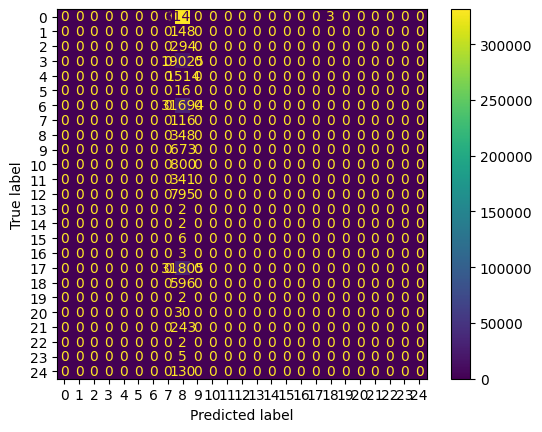

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay(cmatrix)
disp.plot()
plt.show()